In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam,RMSprop
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score,precision_score
import random
import dffuncs as  dff
import itertools
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
from models import ConvNet

D:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# random dataset
filename='Raw_2DMaterials'
trainset = pd.read_table("./Dataset/"+filename+".csv",delimiter=";", header = 0,index_col=None)
X, Y = np.array(trainset.iloc[:,0:-1]),np.array(trainset.iloc[:,-1])
Y=Y.astype('int')

xtrain, xtest, ytrain, ytest = train_test_split(X, Y,stratify=Y, test_size=0.25,random_state=1)

In [6]:
train_model = ConvNet()
train_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 851, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 425, 32)           128       
                                                                 
 batch_normalization (BatchN  (None, 425, 32)          128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 425, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 212, 64)           6208      
                                                                 
 batch_normalization_1 (Batc  (None, 212, 64)          256       
 hNormalization)                                        

In [7]:
checkpoint_filepath = './models/'+filename+'/'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath,
                monitor='val_loss', verbose=1,
                save_best_only=True, save_weights_only = True, mode='min')
train_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = SparseCategoricalCrossentropy(), metrics = ["accuracy"])
history = train_model.fit(xtrain, ytrain, epochs = 100, validation_data = (xtest, ytest), batch_size = 64, callbacks = checkpoint)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 1.6864 - accuracy: 0.5169
Epoch 1: val_loss improved from inf to 2.25083, saving model to ./models/Raw_2DMaterials\
7/7 [==============================] - 28s 275ms/step - loss: 1.6864 - accuracy: 0.5169 - val_loss: 2.2508 - val_accuracy: 0.4765
Epoch 2/100
1/7 [===>..........................] - ETA: 0s - loss: 0.6641 - accuracy: 0.8438
Epoch 2: val_loss improved from 2.25083 to 2.17132, saving model to ./models/Raw_2DMaterials\
7/7 [==============================] - 0s 43ms/step - loss: 0.4526 - accuracy: 0.8539 - val_loss: 2.1713 - val_accuracy: 0.4564
Epoch 3/100
6/7 [========================>.....] - ETA: 0s - loss: 0.1998 - accuracy: 0.9375
Epoch 3: val_loss improved from 2.17132 to 2.10868, saving model to ./models/Raw_2DMaterials\
7/7 [==============================] - 0s 47ms/step - loss: 0.1876 - accuracy: 0.9461 - val_loss: 2.1087 - val_accuracy: 0.4564
Epoch 4/100
1/7 [===>..........................] - ETA: 0

In [12]:
check_model = train_model()
check_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = SparseCategoricalCrossentropy(), metrics = ["accuracy"])
check_model.load_weights(checkpoint_filepath)
check_model.evaluate(xtest, ytest)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'compile'

In [12]:
y_pred = check_model.predict(xtest)
y_preds_ready = y_pred.argmax(axis=1)
print(recall_score(ytest, y_preds_ready, average='macro'))

79/79 [==============================] - 0s 2ms/step
1.0


In [13]:
print(precision_score(ytest, y_preds_ready, average='macro'))

1.0


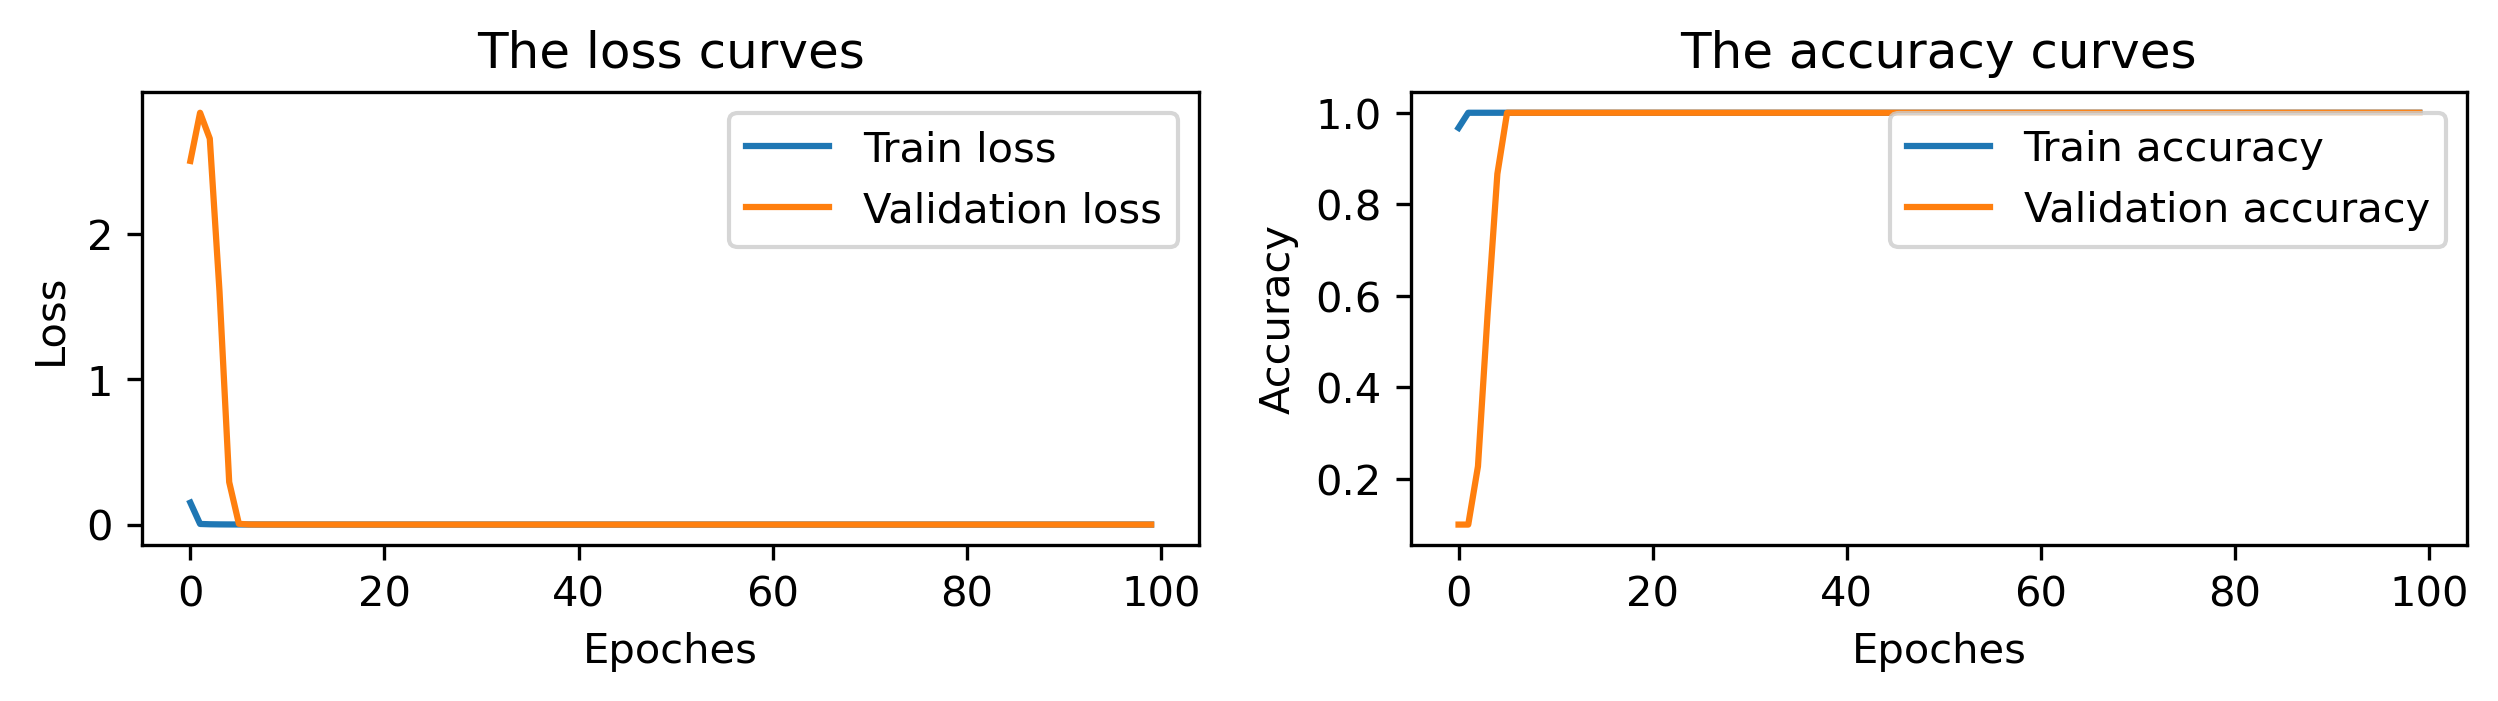

In [14]:
out = pd.DataFrame(history.history)
plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(10,2))

ax = fig.add_subplot(1,2,1 )

ax.plot(out['loss'],label="Train loss")
ax.plot(out['val_loss'], label="Validation loss")
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('The loss curves')
ax.legend()

ax2 = fig.add_subplot(1,2,2 )
ax2.plot(out['accuracy'],label="Train accuracy")
ax2.plot(out['val_accuracy'], label="Validation accuracy")
ax2.set_xlabel('Epoches')
ax2.set_ylabel('Accuracy')
ax2.set_title('The accuracy curves')
ax2.legend()
plt.show()

In [15]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(7,7), text_size=8):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm_norm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm_norm[i, j]*100:.1f}%",
             horizontalalignment="center",
             size=text_size)

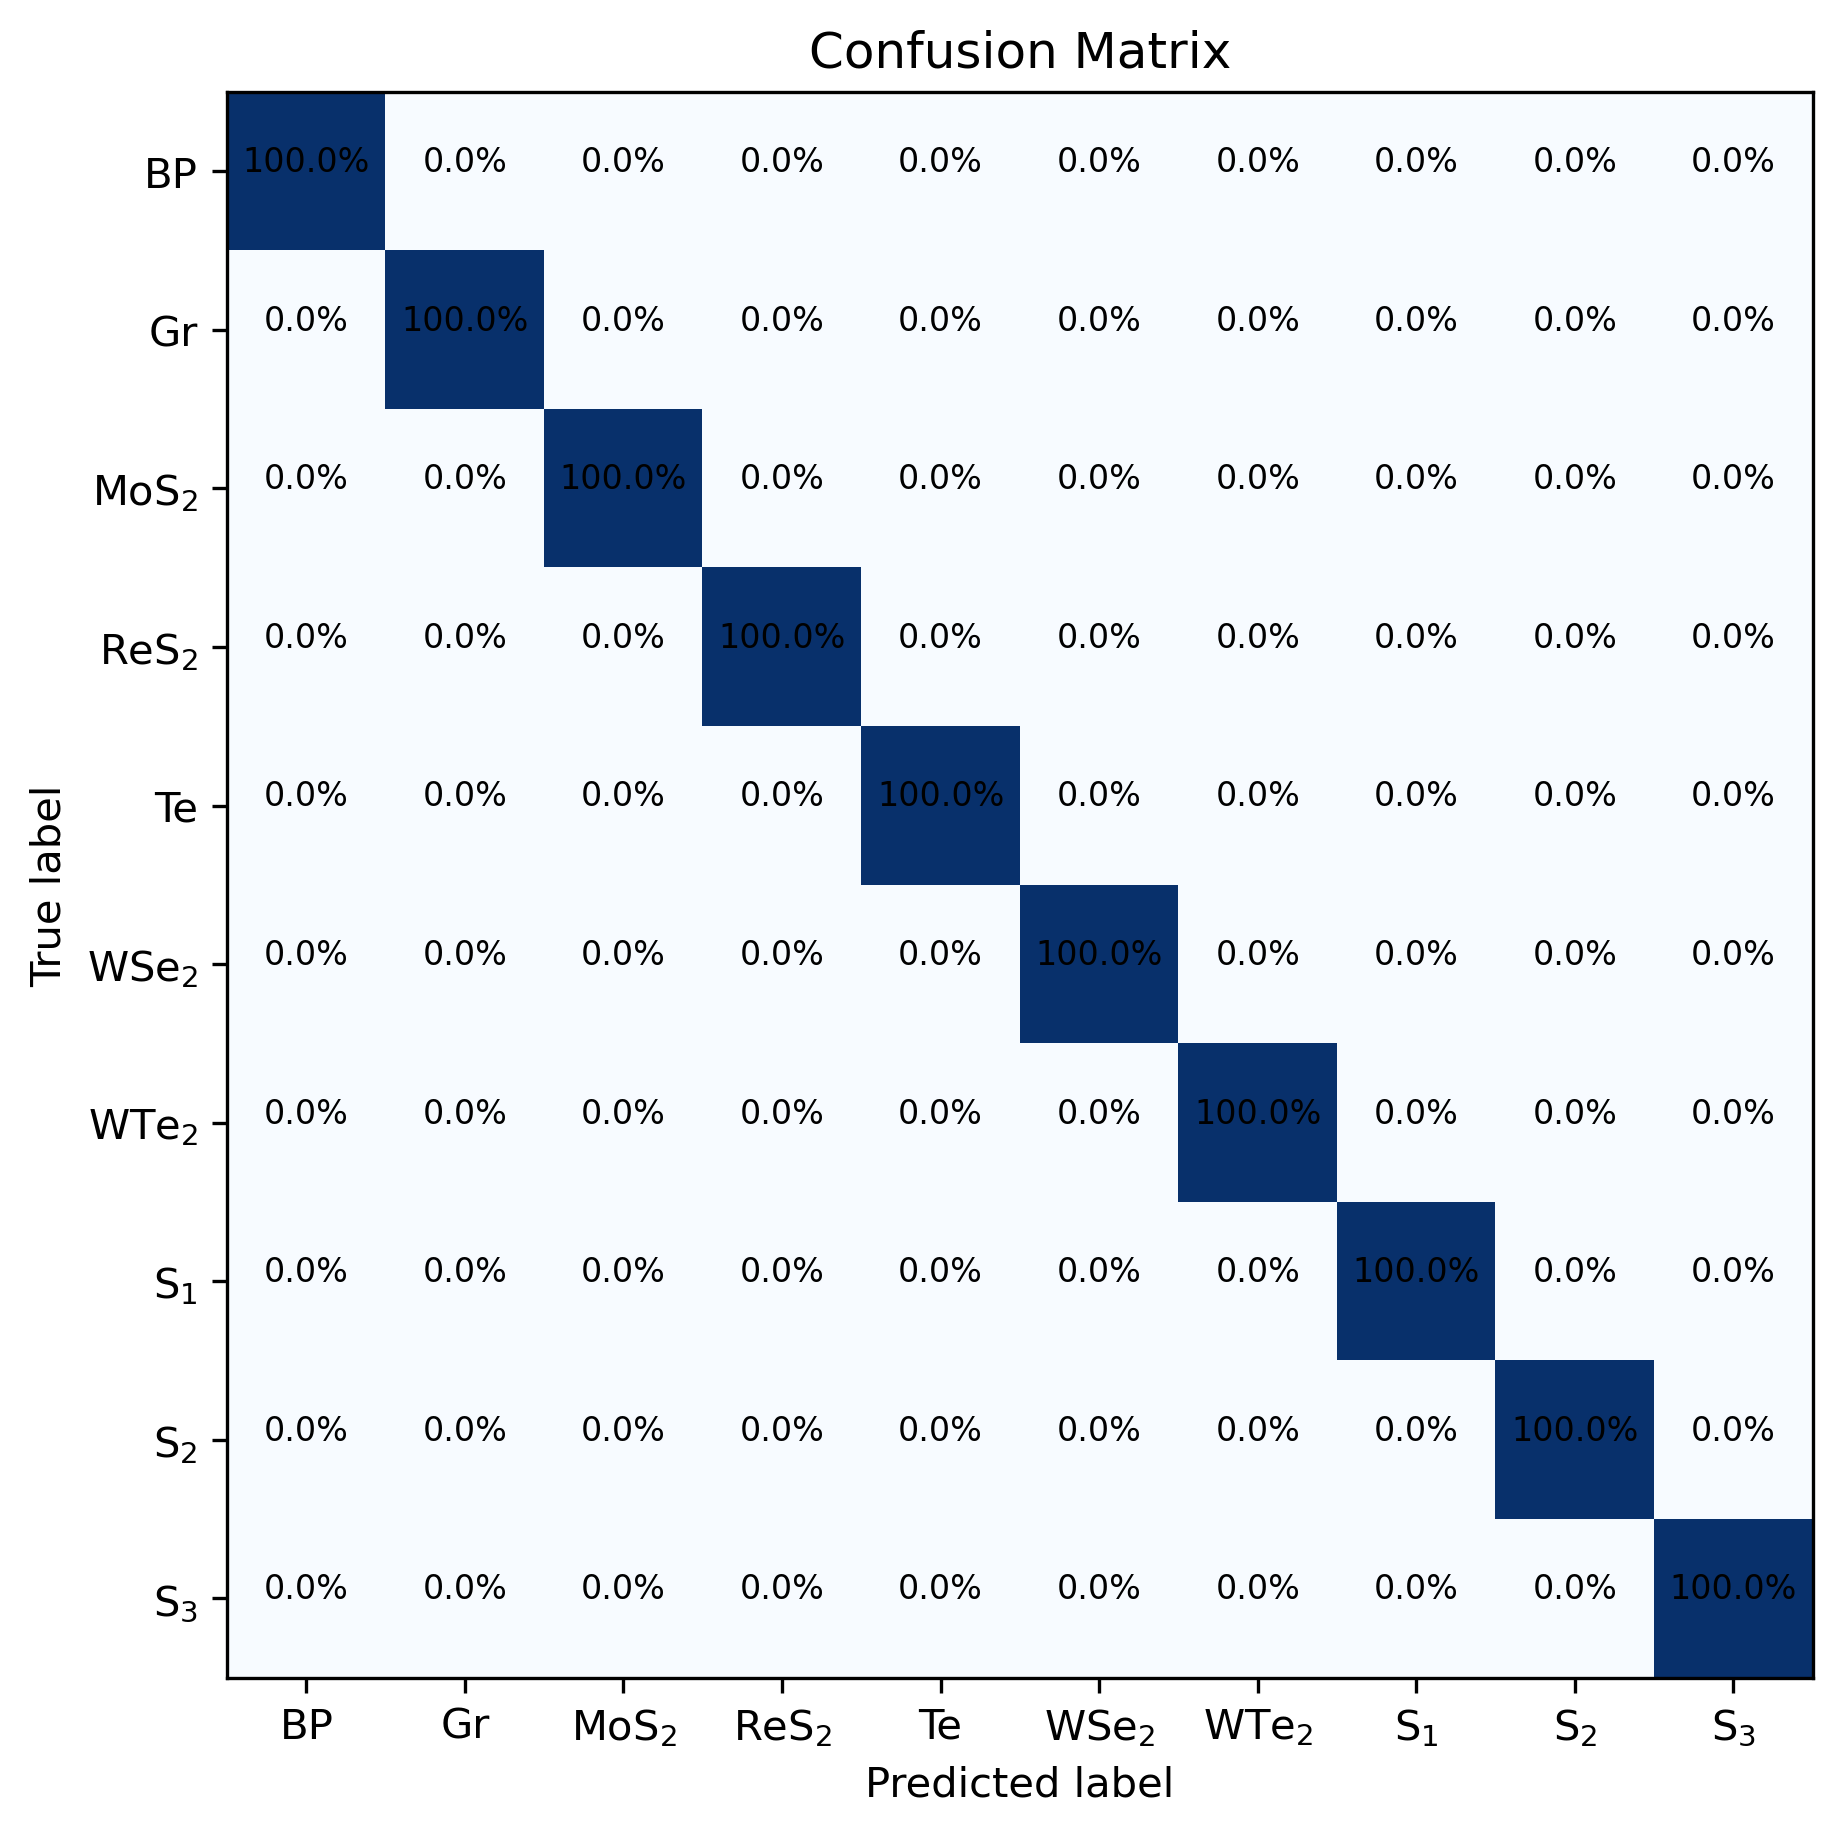

In [16]:
make_confusion_matrix(y_true=ytest,
                      y_pred=y_preds_ready,
                      classes=['BP','Gr','MoS$_2$','ReS$_2$','Te','WSe$_2$','WTe$_2$','S$_1$','S$_2$','S$_3$']
                     )

In [6]:
from sklearn.metrics import confusion_matrix
plt.rcParams['figure.dpi'] = 300
def make_confusion_matrix(cm, classes=None, figsize=(7,7), text_size=8):

    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm_norm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(n_classes)

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm_norm[i, j]*100:.1f}%",
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > threshold else "black",
                 size=text_size)

    plt.show()

def ready_model():
    model_train = model()
    return model_train


def get_model_name(k, name):
    return 'model_'+name+str(k)+'.h5'

def KFoldcnn(filename):
    num=10
    kfold = KFold(n_splits=num, shuffle=True)
    trainset = pd.read_table('./Dataset/2D/'+filename +'.csv',delimiter=";", header = 0)
    X, Y = np.array(trainset.iloc[:,0:-1]),np.array(trainset.iloc[:,-1])
    Y=Y.astype('int')


    name = "crossval"
    accuracy = []
    recall = []
    precision = []
    sum_conf_matrix = np.zeros((10, 10))
    fold_no = 1
    for train, test  in kfold.split(X, Y):
        train_model = ready_model()
        train_model.compile(optimizer = Adam(learning_rate=0.0001),
                            loss = SparseCategoricalCrossentropy(),
                            metrics = ['accuracy'])
        print(f'training fold number {fold_no}')

        save_dir = './models/KFold/'+ filename +'crossval/'
        checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_no, name),
                monitor='val_accuracy', verbose=1,
                save_best_only=True, mode='max')

        callbacks_list = [checkpoint]

        history = train_model.fit(X[train], Y[train], epochs = 100,
                                validation_data = (X[test], Y[test]),
                                batch_size = 64,
                                callbacks = callbacks_list,
                                verbose = 0)


        train_model.load_weights(save_dir+get_model_name(fold_no, name))
        scores = train_model.evaluate(X[test], Y[test], verbose=0)
        accuracy.append(scores[1])
        y_pred = train_model.predict(X[test])
        y_preds_ready = y_pred.argmax(axis=1)
        recall.append(recall_score(Y[test], y_preds_ready, average='macro'))
        precision.append(precision_score(Y[test], y_preds_ready, average='macro'))
        conf_matrix = confusion_matrix(Y[test], y_preds_ready, labels=list(range(10)))
        sum_conf_matrix += conf_matrix
        fold_no+=1

    print("Score per fold:")
    for i in range(num):
        print(f'Fold {i + 1} - Accuracy: {accuracy[i] * 100}%, Recall: {recall[i] * 100}%, Precision: {precision[i] * 100}%')

    avg_accuracy = sum(accuracy) / len(accuracy) * 100
    avg_recall = sum(recall) / len(recall) * 100
    avg_precision = sum(precision) / len(precision) * 100
    print(f"Average Accuracy: {avg_accuracy}%, Average Recall: {avg_recall}%, Average Precision: {avg_precision}%")


    avg_conf_matrix = sum_conf_matrix / 10
    print('Average Confusion Matrix:')
    make_confusion_matrix(avg_conf_matrix, classes=['BP', 'Gr', 'MoS$_2$', 'ReS$_2$', 'Te', 'WSe$_2$', 'WTe$_2$', 'S$_1$', 'S$_2$', 'S$_3$'])



training fold number 1

Epoch 1: val_accuracy improved from -inf to 0.09100, saving model to ./models/KFold/2D_DDPM1119crossval\model_crossval1.h5

Epoch 2: val_accuracy improved from 0.09100 to 0.09800, saving model to ./models/KFold/2D_DDPM1119crossval\model_crossval1.h5

Epoch 3: val_accuracy improved from 0.09800 to 0.47400, saving model to ./models/KFold/2D_DDPM1119crossval\model_crossval1.h5

Epoch 4: val_accuracy improved from 0.47400 to 0.88700, saving model to ./models/KFold/2D_DDPM1119crossval\model_crossval1.h5

Epoch 5: val_accuracy improved from 0.88700 to 1.00000, saving model to ./models/KFold/2D_DDPM1119crossval\model_crossval1.h5

Epoch 6: val_accuracy did not improve from 1.00000

Epoch 7: val_accuracy did not improve from 1.00000

Epoch 8: val_accuracy did not improve from 1.00000

Epoch 9: val_accuracy did not improve from 1.00000

Epoch 10: val_accuracy did not improve from 1.00000

Epoch 11: val_accuracy did not improve from 1.00000

Epoch 12: val_accuracy did not

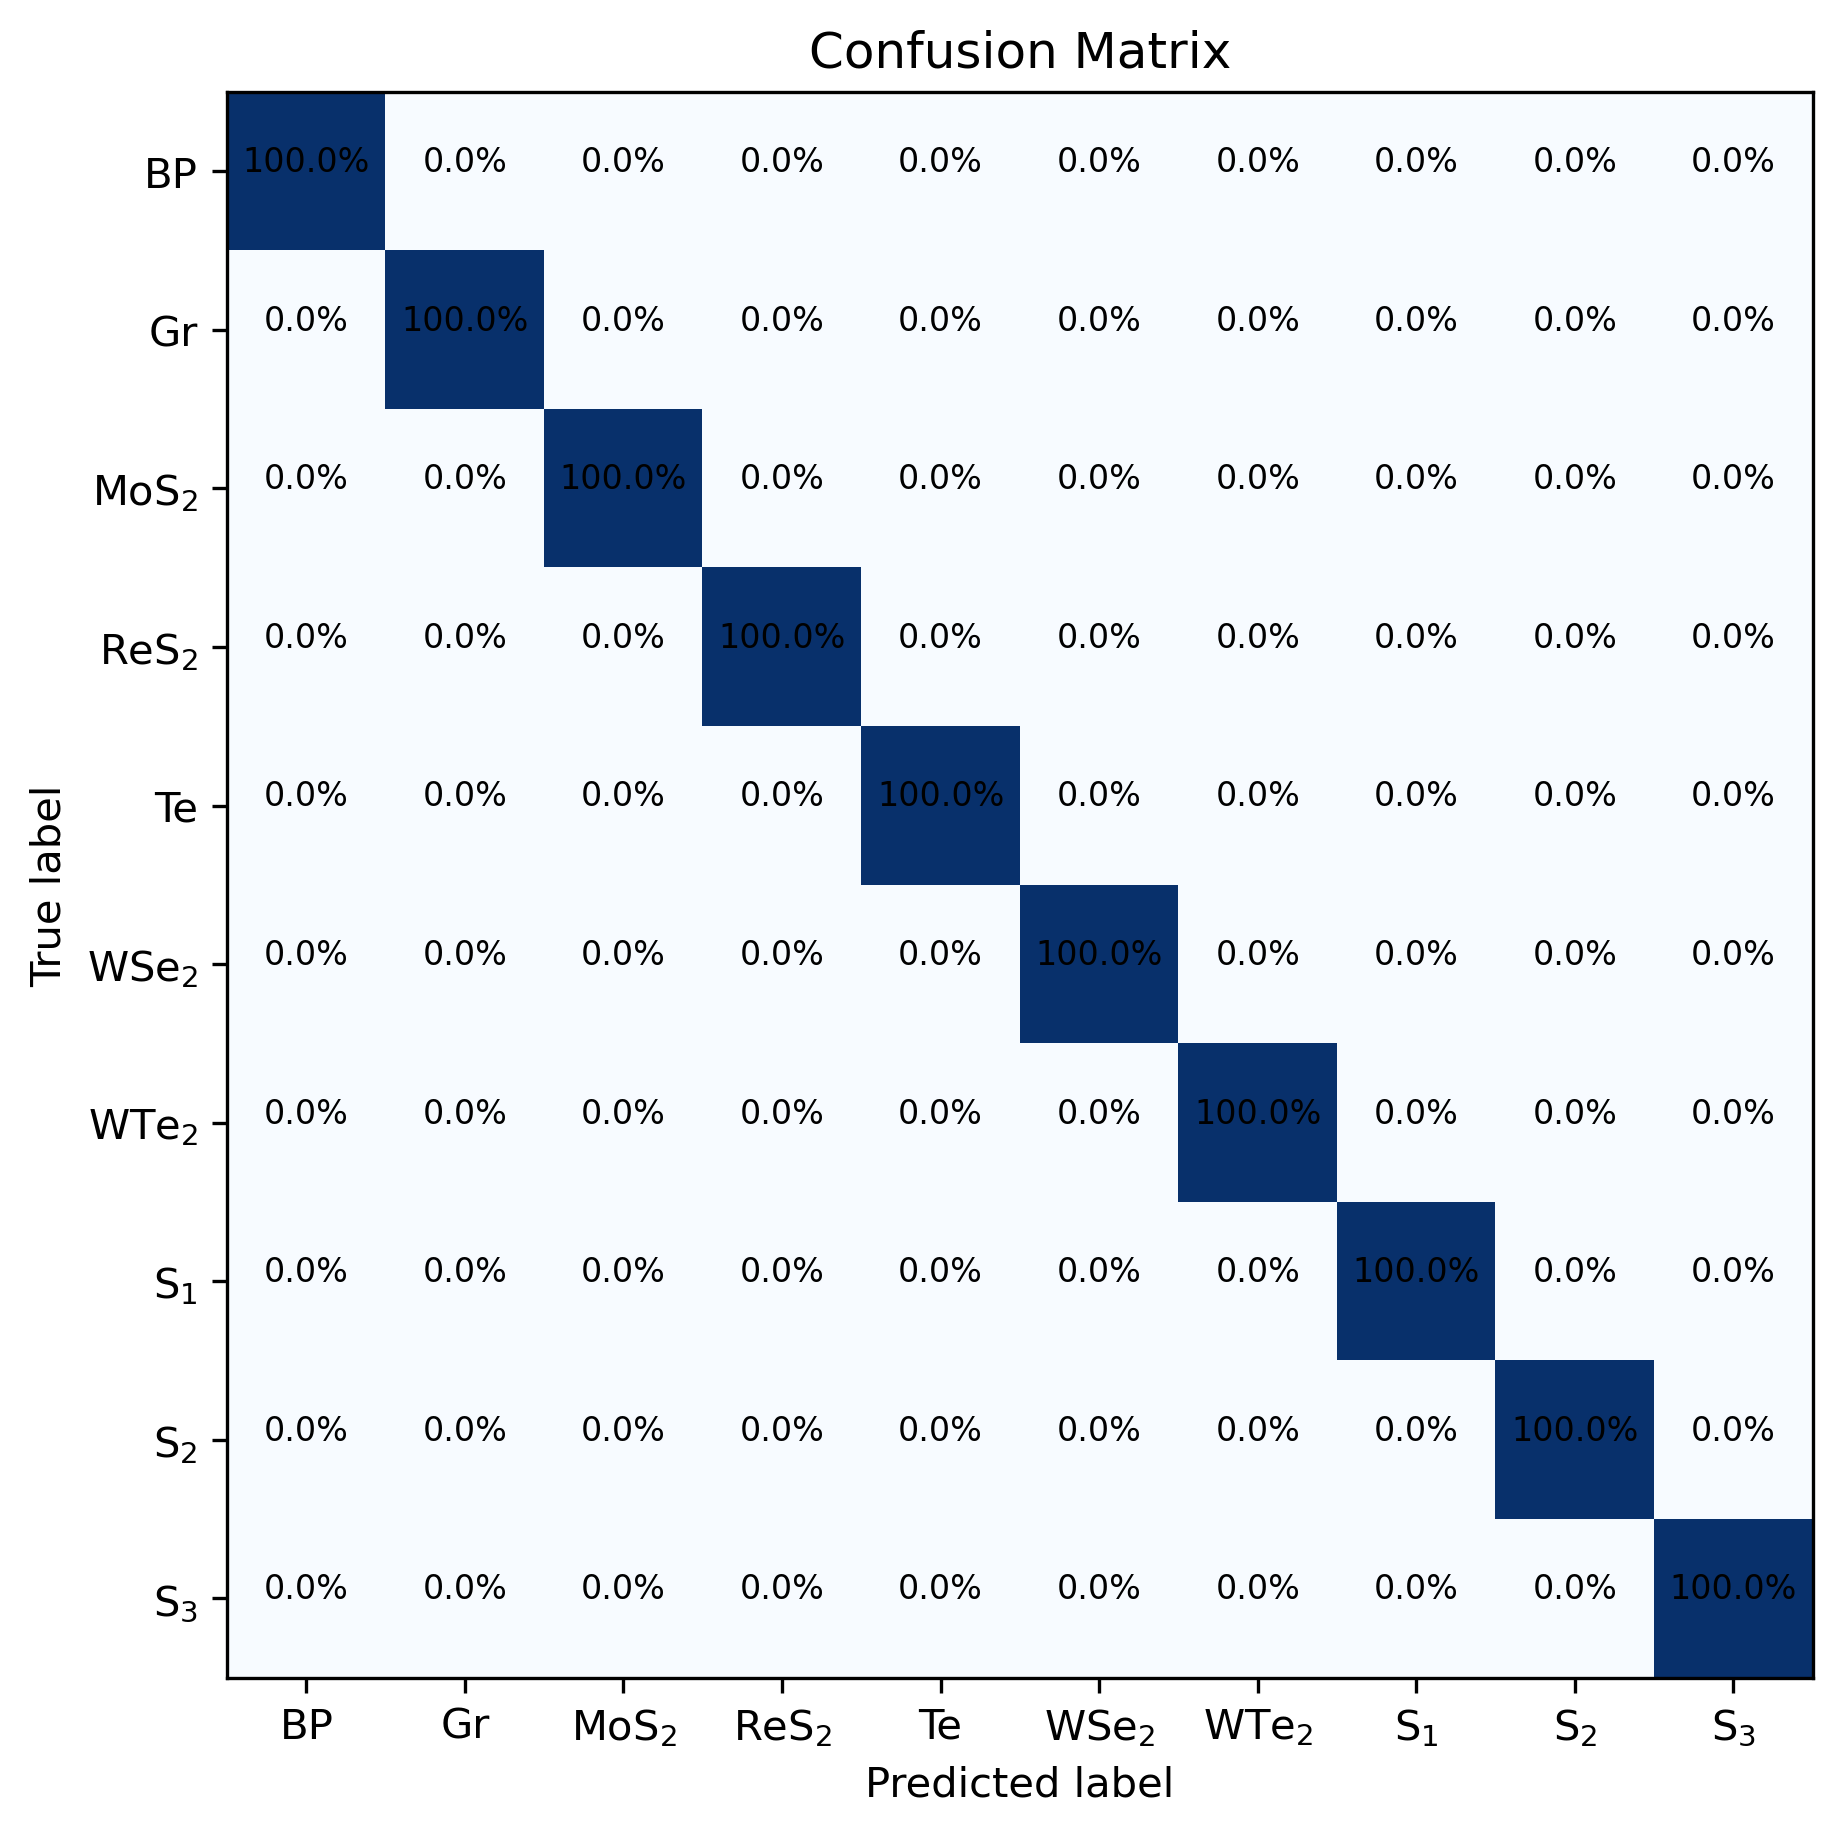

In [7]:
KFoldcnn('2D_DDPM1119')